In [ ]:
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF

Downloading...
From (original): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
From (redirected): https://drive.google.com/uc?id=1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF&confirm=t&uuid=56e75bac-73b8-42ec-88f1-5e2866688dc8
To: /content/data.zip
100% 76.1M/76.1M [00:04<00:00, 17.9MB/s]


In [ ]:
!unzip data

Archive:  data.zip
   creating: data/
   creating: data/.ipynb_checkpoints/
   creating: data/test/
   creating: data/test/American_egret/
  inflating: data/test/American_egret/n02009912_2473.JPEG  
   creating: data/test/Doberman/
  inflating: data/test/Doberman/n02107142_52285.JPEG  
   creating: data/test/Rhodesian_ridgeback/
  inflating: data/test/Rhodesian_ridgeback/n02087394_18723.JPEG  
   creating: data/test/African_crocodile/
  inflating: data/test/African_crocodile/n01697457_18534.JPEG  
   creating: data/test/Lakeland_terrier/
  inflating: data/test/Lakeland_terrier/n02095570_4644.JPEG  
   creating: data/test/ambulance/
  inflating: data/test/ambulance/n02701002_2311.JPEG  
   creating: data/test/apiary/
  inflating: data/test/apiary/n02727426_4398.JPEG  
   creating: data/test/bannister/
  inflating: data/test/bannister/n02788148_47071.JPEG  
   creating: data/test/basketball/
  inflating: data/test/basketball/n02802426_12693.JPEG  
   creating: data/test/barn_spider/
  in

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
ROOT = 'data'
class_name = sorted(list(os.listdir(f'{ROOT}/train'))) #sắp xếp thư mục train trong data

In [ ]:
def read_image_from_path(file_path, size):
  """
  Đọc hình ảnh từ đường dẫn, chuyển đổi thành RGB và thay đổi kích thước. Trả về mảng NumPy.
  """
  image = Image.open(file_path).convert('RGB').resize(size) #đọc và convert hình ảnh sang np array vói kích thước size cụ thể
  return np.array(image)

def folder_to_images_paths(folder_path, size):
  """
  Đọc tất cả hình ảnh từ một thư mục, thay đổi kích thước và lưu vào mảng numpy. Trả về tuple chứa mảng hình ảnh và list đường dẫn tương ứng.
  """
  list_dir = [folder_path + '/' + name for name in os.listdir(folder_path)] #tạo 1 list chứa từng phần tử là đường dẫn từng thư mục trong folder
  image_array = np.zeros(shape=(len(list_dir),*size,3)) #Tạo một mảng NumPy rỗng với kích thước được giải nén từ size
  image_paths = []
  for i, path in enumerate(list_dir):
    image_array[i] = read_image_from_path(path, size) #mỗi phần tử trong array sẽ chứa dữ kiểu từ 1 hình ảnh
    image_paths.append(path) #thêm đường dẫn vào list, đường dẫn hình ảnh tương ứng
  return image_array, image_paths


In [ ]:
def plot_result(query_path,ls_path_score, reverse):
  """
  Vẽ hình ảnh truy vấn và 5 hình ảnh gần giống nhất.
  """
  fig = plt.figure(figsize=(10,10)) #Tạo plot lớn với size 10x10
  fig.add_subplot(2,3,1) #tạo subplot 2 hàng 3 cột, tức 6 ô chứa hình nhỏ
  plt.imshow(read_image_from_path(query_path,size=(224,224))) #kích thước 448x448
  plt.title(f"Query Image: {query_path.split('/')[2]}", fontsize=15)
  plt.axis('off')
  for i,file_path in enumerate(sorted(ls_path_score,key=lambda x:x[1], reverse=reverse)[:5],2): #Dựa trên tuple điểm số ls, sắp xếp dựa trên phần tử thứ 2 là điểm số, chỉ 5 phần tử,  True sẽ sắp xếp giảm dần, False sẽ tăng lên
    fig.add_subplot(2,3,i)
    plt.imshow(read_image_from_path(file_path[0], size=(224,224)))
    plt.title(f"Top{i-1}: {file_path[0].split('/')[2]}", fontsize=15)
    plt.axis('off')
  plt.show()

# Mahattan distance L1 - Absolute different

In [ ]:
def L1_mahattan_score(query, data):
  axis_batch_size = tuple(range(1,len(data.shape))) #tạo một tuple chứa các chiều của data
  return np.sum(np.abs(data-query), axis=axis_batch_size) #tính tổng dựa trên các chiều data

In [ ]:
def calculate_L1_score(root_path,query_path,size):
  """
  Tạo tuple chứa hình ảnh query và list đường dẫn hình ảnh gần giống nhất
  """
  query_image = read_image_from_path(query_path, size)
  L1_paths_scores = []
  for folder in os.listdir(root_path):
    if folder in class_name:
      path_folder = root_path + folder #tạo đường dẫn từ root tới từng folder cụ thể
      images_array, images_path = folder_to_images_paths(path_folder, size) #Với mỗi hình ảnh có được đường dẫn tương ứng
      L1_scores = L1_mahattan_score(query_image, images_array) #tinh toán hình query và từng hình ảnh trong folder đó
      L1_paths_scores.extend(list(zip(images_path, L1_scores))) #kết quả lưu vào 1 list, từng phần tử là đường dẫn hình ảnh và số điểm tương ứng của hình ảnh và hình query
  return query_image, L1_paths_scores


# Euclidean distance L2 - Measn Square diffenrence

In [ ]:
def L2_euclidean_score(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  return np.mean((data - query)**2, axis=axis_batch_size)

In [ ]:
def calculate_L2_score(root_path,query_path,size):
  query_image = read_image_from_path(query_path, size)
  L2_paths_scores = []
  for folder in os.listdir(root_path):
    if folder in class_name:
      path_folder = root_path + folder
      images_array, images_path = folder_to_images_paths(path_folder, size)
      L2_scores = L2_euclidean_score(query_image, images_array)
      L2_paths_scores.extend(list(zip(images_path, L2_scores)))
  return query_image, L2_paths_scores



# Cosine Similarity

In [ ]:
def cosine_similarity(query, data):
  axis_batch_size = tuple(range(1,len(data.shape)))
  query_norm = np.sqrt(np.sum(query**2))
  data_norm = np.sqrt(np.sum(data**2))
  return np.sum(query*data, axis=axis_batch_size)/(query_norm*data_norm + np.finfo(float).eps) #eps để tránh trường hợp chia cho 0

In [ ]:
def calculate_cosine_score(root_path,query_path,size):
  query_image = read_image_from_path(query_path, size)
  cosine_paths_scores = []
  for folder in os.listdir(root_path):
    if folder in class_name:
      path_folder = root_path + folder
      images_array, images_path = folder_to_images_paths(path_folder, size)
      cosine_scores = cosine_similarity(query_image, images_array)
      cosine_paths_scores.extend(list(zip(images_path, cosine_scores)))
  return query_image, cosine_paths_scores

# Correlation Coefficient

In [ ]:
def correlation_coefficient(query, data):
    axis_batch_size = tuple(range(1,len(data.shape)))
    query_mean = query - np.mean(query)
    data_mean = data - np.mean(data)
    query_norm = np.sqrt(np.sum(query_mean**2))
    data_norm = np.sqrt(np.sum(data_mean**2))

    return np.sum(data_mean * query_mean, axis=axis_batch_size) / (query_norm*data_norm + np.finfo(float).eps)

In [ ]:
def calculate_correlation_coefficient_score(root_path, query_path, size):
    query_image = read_image_from_path(query_path, size)
    cc_paths_scores = []
    for folder in os.listdir(root_path):
        if folder in class_name:
            path_folder = root_path + folder
            images_array, images_path = folder_to_images_paths(path_folder, size)
            cc_scores = correlation_coefficient(query_image, images_array)
            cc_paths_scores.extend(list(zip(images_path, cc_scores)))
    return query_image, cc_paths_scores

# Run codes in 4 calculation methods

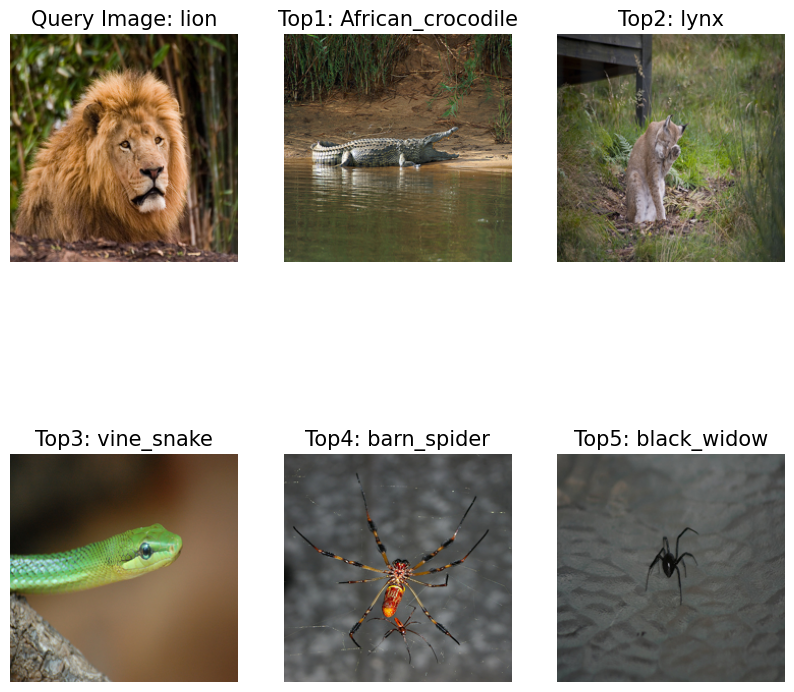

In [ ]:
"""
Đoạn code thực hiện tính toán L1 manhattan absolute different score và vẽ hình ảnh truy vấn và hình ảnh gần giống nhất.
"""
root_path = f"{ROOT}/train/"
query_path = f"{ROOT}/test/lion/n02129165_13728.JPEG"
size = (224,224)
query_image_L1, L1_paths_scores = calculate_L1_score(root_path, query_path, size)
plot_result(query_path, L1_paths_scores, reverse=False)


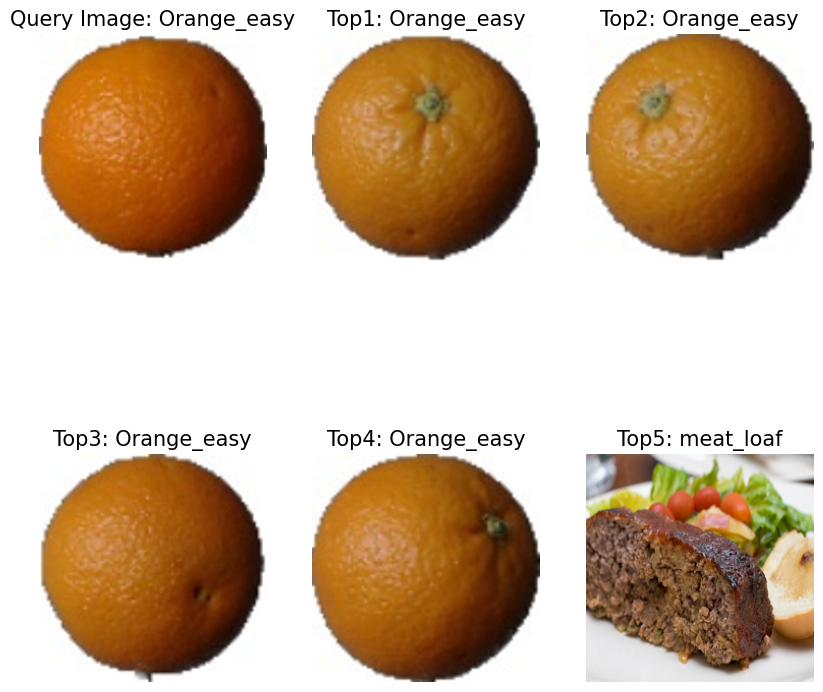

In [ ]:
"""
Đoạn code thực hiện tính toán L2 euclidean mean square difference score và vẽ hình ảnh truy vấn và hình ảnh gần giống nhất.
"""
root_path  = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (224, 224)
query_image_L2, L2_paths_scores = calculate_L2_score(root_path, query_path, size)
plot_result(query_path, L2_paths_scores, reverse=False)

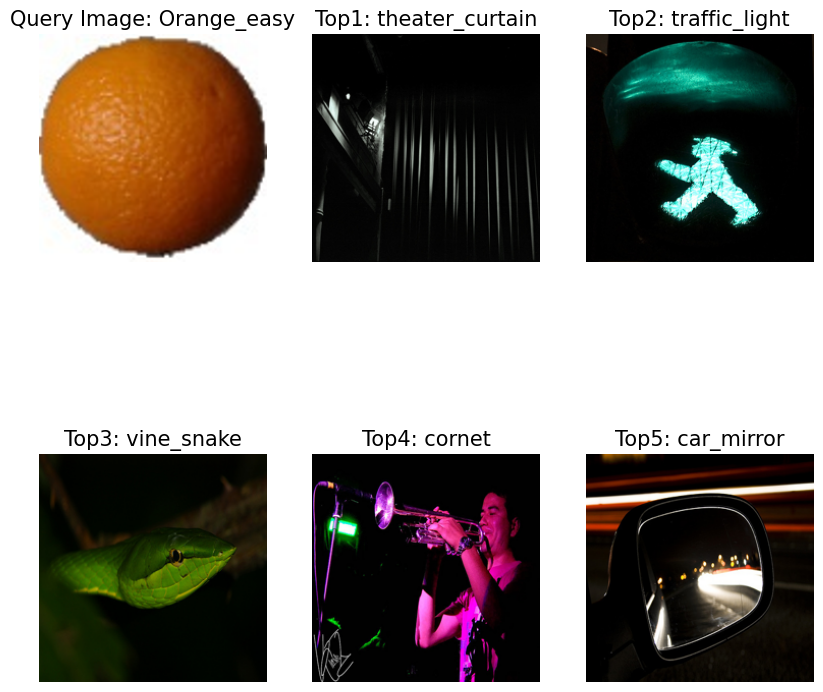

In [ ]:
"""
Đoạn code thực hiện tính toán cosine similarity score và vẽ hình ảnh truy vấn và hình ảnh gần giống nhất.
"""
root_path  = f"{ROOT}/train/"
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
size = (224,224)
query_image_cosine, cosine_paths_scores = calculate_cosine_score(root_path, query_path, size)
plot_result(query_path, cosine_paths_scores, reverse=False)

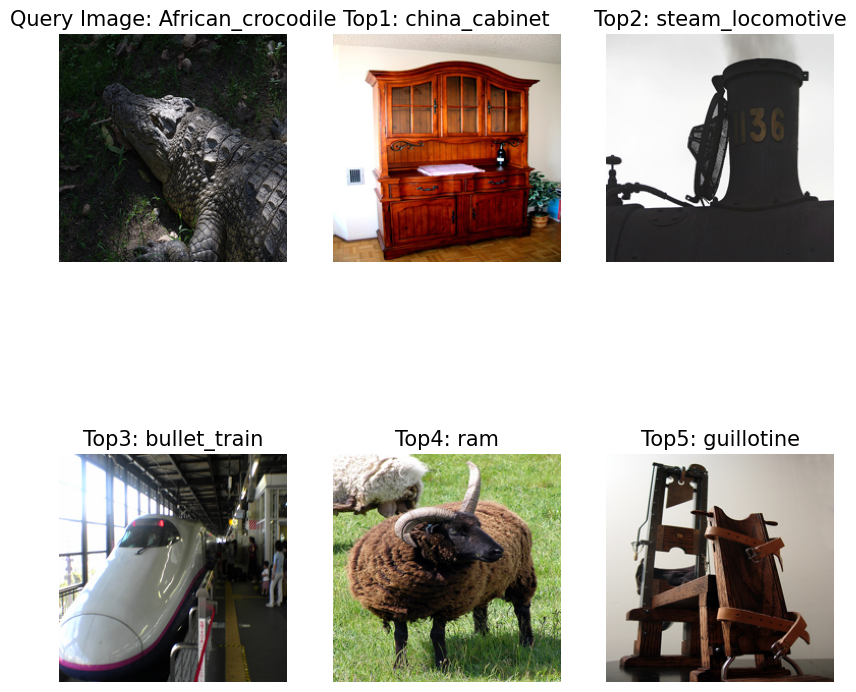

In [ ]:
"""
Doạn code thực hiện tính toán correlation coefficient và vẽ hình ảnh truy vấn và hình ảnh gần giống nhất.
"""
root_path  = f"{ROOT}/train/"
query_path = f"{ROOT}/test/African_crocodile/n01697457_18534.JPEG"
size = (224,224)
query_image_cc, cc_paths_scores = calculate_correlation_coefficient_score(root_path, query_path, size)
plot_result(query_path, cc_paths_scores, reverse=False)